# LSN Exercise 07.4 - MC NVT vs MD NVE Comparison

## Physical Properties Comparison

**Complete analysis comparing:**
- Potential energy per particle U/N
- Pressure P (with virial theorem)
- Radial distribution function g(r)
- Statistical uncertainties and agreement

**Simulation conditions:**
- Liquid phase: ρ* = 0.8, T* = 1.1
- Cut-off radius: r*_c = 2.5
- N = 108 particles
- MC (NVT ensemble)
- MD (NVE ensemble)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
import os

# Enhanced plot configuration for publication quality
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 14,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.family': 'serif',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2,
    'axes.linewidth': 1.5,
    'xtick.major.size': 8,
    'ytick.major.size': 8
})

# Color scheme
colors = {
    'MD': '#1f77b4',  # Blue
    'MC': '#2ca02c',  # Green
    'comparison': '#ff7f0e'  # Orange
}

## Data Loading and Preprocessing

In [5]:
def load_complete_simulation_data(simulation_type):
    """Load complete data from final MC/MD simulation results"""
    base_path = f"RESULTS/{simulation_type}_production_final/"

    try:
        data_dict = {}

        # Load potential energy (instantaneous values)
        pe_file = f"{base_path}potential_energy.dat"
        if os.path.exists(pe_file):
            with open(pe_file, 'r') as f:
                lines = f.readlines()

            pe_values = []
            for line in lines[1:]:  # Skip header
                line = line.strip()
                if line and not line.startswith('#'):
                    try:
                        pe_values.append(float(line))
                    except ValueError:
                        continue

            data_dict['potential_energy'] = np.array(pe_values)

        # Load pressure (instantaneous values)
        pressure_file = f"{base_path}pressure.dat"
        if os.path.exists(pressure_file):
            with open(pressure_file, 'r') as f:
                lines = f.readlines()

            pressure_values = []
            for line in lines[1:]:  # Skip header
                line = line.strip()
                if line and not line.startswith('#'):
                    try:
                        pressure_values.append(float(line))
                    except ValueError:
                        continue

            data_dict['pressure'] = np.array(pressure_values)

        # Load g(r) with proper handling of duplicate r values (FIXED!)
        gofr_file = f"{base_path}gofr.dat"
        if os.path.exists(gofr_file):
            try:
                # Load raw data
                raw_gofr_data = np.loadtxt(gofr_file, comments='#')
                
                # The file contains multiple blocks with same r values - we need to average them
                # Group by r value and calculate mean g(r) and error
                import pandas as pd
                
                df = pd.DataFrame(raw_gofr_data, columns=['r', 'gofr', 'error'])
                
                # Group by r and calculate statistics
                grouped = df.groupby('r').agg({
                    'gofr': 'mean',           # Average g(r) across blocks
                    'error': lambda x: np.sqrt(np.mean(x**2))  # RMS error
                }).reset_index()
                
                # Convert back to numpy array
                data_dict['gofr'] = grouped.values
                
            except Exception as e:
                print(f"Error loading {simulation_type} g(r): {e}")

        return data_dict

    except Exception as e:
        print(f"Error loading {simulation_type} data: {e}")
        return None

# Load final simulation data
md_data = load_complete_simulation_data("MD")
mc_data = load_complete_simulation_data("MC")

if md_data and mc_data:
    pass
else:
    print("Error loading simulation data")

## Statistical Analysis Functions

In [7]:
def calculate_statistics(data, method='block', block_size=1000):
    """Calculate mean and uncertainty using different methods"""
    
    if method == 'simple':
        mean = np.mean(data)
        uncertainty = np.std(data) / np.sqrt(len(data))
        
    elif method == 'block':
        n_blocks = len(data) // block_size
        if n_blocks < 2:
            return calculate_statistics(data, 'simple')
        
        # Reshape into blocks and calculate block averages
        truncated_data = data[:n_blocks * block_size]
        blocks = truncated_data.reshape(n_blocks, block_size)
        block_averages = np.mean(blocks, axis=1)
        
        mean = np.mean(block_averages)
        uncertainty = np.std(block_averages, ddof=1) / np.sqrt(n_blocks)
        
    return mean, uncertainty

def statistical_comparison(value1, error1, value2, error2, names=('Method 1', 'Method 2')):
    """Compare two values with uncertainties"""
    diff = abs(value1 - value2)
    combined_error = np.sqrt(error1**2 + error2**2)
    
    if combined_error > 0:
        sigma_diff = diff / combined_error
        if sigma_diff < 1:
            agreement = "Excellent"
        elif sigma_diff < 2:
            agreement = "Good"
        else:
            agreement = "Poor"
    else:
        sigma_diff = 0
        agreement = "Cannot assess"
    
    return {
        'difference': diff,
        'sigma_difference': sigma_diff,
        'agreement': agreement,
        'summary': f"{names[0]}: {value1:.6f} ± {error1:.6f}\n{names[1]}: {value2:.6f} ± {error2:.6f}\nDiff: {diff:.6f} ({sigma_diff:.1f}σ) - {agreement}"
    }

 *"Compare MC results with MD NVE simulations for potential energy, pressure, and radial distribution function"*

In [9]:
if md_data and mc_data:
    # Calculate final statistics for all properties
    results = {}
    
    # Potential Energy U/N
    if 'potential_energy' in md_data and 'potential_energy' in mc_data:
        md_pe_mean, md_pe_error = calculate_statistics(md_data['potential_energy'])
        mc_pe_mean, mc_pe_error = calculate_statistics(mc_data['potential_energy'])
        
        results['potential_energy'] = {
            'MD': (md_pe_mean, md_pe_error),
            'MC': (mc_pe_mean, mc_pe_error),
            'comparison': statistical_comparison(md_pe_mean, md_pe_error, mc_pe_mean, mc_pe_error, ('MD NVE', 'MC NVT'))
        }
    
    # Pressure P
    if 'pressure' in md_data and 'pressure' in mc_data:
        md_p_mean, md_p_error = calculate_statistics(md_data['pressure'])
        mc_p_mean, mc_p_error = calculate_statistics(mc_data['pressure'])
        
        results['pressure'] = {
            'MD': (md_p_mean, md_p_error),
            'MC': (mc_p_mean, mc_p_error),
            'comparison': statistical_comparison(md_p_mean, md_p_error, mc_p_mean, mc_p_error, ('MD NVE', 'MC NVT'))
        }
else:
    print("Cannot perform analysis - simulation data not available")

## Visualization

/var/folders/6t/10bk3qrj7r3grtsfz53v_gsw0000gn/T/ipykernel_8347/1684364166.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


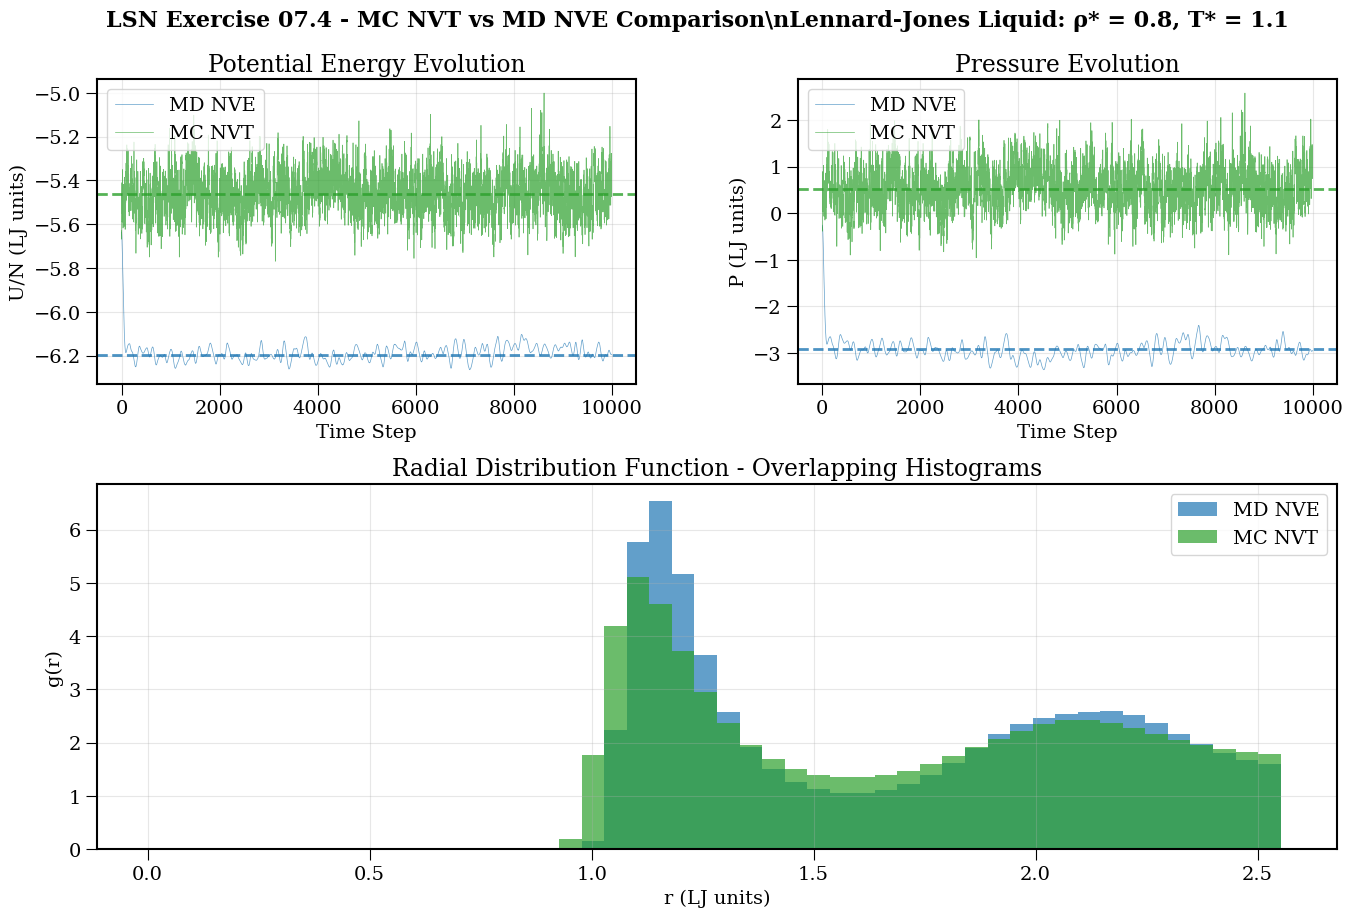

In [11]:
if md_data and mc_data and 'results' in locals():
    # Create simplified comparison figure
    fig = plt.figure(figsize=(16, 10))
    
    # Layout: 2x2 grid
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2], hspace=0.3, wspace=0.3)
    
    # 1. Potential Energy Time Series (first 10k points)
    ax1 = fig.add_subplot(gs[0, 0])
    max_show = 10000
    md_steps = np.arange(min(len(md_data['potential_energy']), max_show))
    mc_steps = np.arange(min(len(mc_data['potential_energy']), max_show))
    
    ax1.plot(md_steps, md_data['potential_energy'][:len(md_steps)], 
             color=colors['MD'], alpha=0.7, linewidth=0.5, label='MD NVE')
    ax1.plot(mc_steps, mc_data['potential_energy'][:len(mc_steps)], 
             color=colors['MC'], alpha=0.7, linewidth=0.5, label='MC NVT')
    
    # Add mean lines
    if 'potential_energy' in results:
        ax1.axhline(y=results['potential_energy']['MD'][0], color=colors['MD'], 
                   linestyle='--', linewidth=2, alpha=0.8)
        ax1.axhline(y=results['potential_energy']['MC'][0], color=colors['MC'], 
                   linestyle='--', linewidth=2, alpha=0.8)
    
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('U/N (LJ units)')
    ax1.set_title('Potential Energy Evolution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Pressure Time Series (first 10k points)
    ax2 = fig.add_subplot(gs[0, 1])
    if 'pressure' in md_data and 'pressure' in mc_data:
        ax2.plot(md_steps, md_data['pressure'][:len(md_steps)], 
                 color=colors['MD'], alpha=0.7, linewidth=0.5, label='MD NVE')
        ax2.plot(mc_steps, mc_data['pressure'][:len(mc_steps)], 
                 color=colors['MC'], alpha=0.7, linewidth=0.5, label='MC NVT')
        
        # Add mean lines
        if 'pressure' in results:
            ax2.axhline(y=results['pressure']['MD'][0], color=colors['MD'], 
                       linestyle='--', linewidth=2, alpha=0.8)
            ax2.axhline(y=results['pressure']['MC'][0], color=colors['MC'], 
                       linestyle='--', linewidth=2, alpha=0.8)
    
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('P (LJ units)')
    ax2.set_title('Pressure Evolution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Versione alternativa con istogrammi sovrapposti (più compatta)
    ax3 = fig.add_subplot(gs[1, :])
    if 'gofr' in md_data and 'gofr' in mc_data:
        md_gofr_data = md_data['gofr']
        mc_gofr_data = mc_data['gofr']
    
        r_md = md_gofr_data[:, 0]
        gofr_md = md_gofr_data[:, 1]
        r_mc = mc_gofr_data[:, 0]
        gofr_mc = mc_gofr_data[:, 1]
        
        # Istogrammi sovrapposti con trasparenza
        ax3.hist(r_md, weights=gofr_md, bins=50, alpha=0.7, 
                 color=colors['MD'], label='MD NVE', density=False)
        ax3.hist(r_mc, weights=gofr_mc, bins=50, alpha=0.7, 
                 color=colors['MC'], label='MC NVT', density=False)
        
        ax3.set_xlabel('r (LJ units)')
        ax3.set_ylabel('g(r)')
        ax3.set_title('Radial Distribution Function - Overlapping Histograms')
        ax3.legend()
        ax3.grid(True, alpha=0.3)    
    # Overall title
    fig.suptitle('LSN Exercise 07.4 - MC NVT vs MD NVE Comparison\\nLennard-Jones Liquid: ρ* = 0.8, T* = 1.1', 
                fontsize=16, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Cannot create visualization - data not available")